In [6]:

import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split





In [7]:

seq_length=5
x_data_dim=4
batch_size=100
min_max_normalization_flag=True


In [8]:

data_dir = '../dataset'
fname = os.path.join(data_dir, 'a_company_stock.csv')
df = pd.read_csv(fname)

dataset=df.copy()
ori_Y=dataset.pop("Close")
ori_X=dataset.copy()

ori_X=ori_X[700:1226] ### 행 700~1225까지 데이터 가져오기
ori_Y=ori_Y[700:1226] ### 행 700~1225까지 데이터 가져오기


In [9]:

X_train, X_test, Y_train, Y_test = train_test_split(ori_X,ori_Y, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val= train_test_split(X_train,Y_train, test_size=0.2, shuffle=False)


In [10]:

## 데이터의 min , max, mean, std 값 구하기.
dataset_stats = X_train.describe()
dataset_stats = dataset_stats.transpose()

## data normalization
def min_max_norm(x):
  return (x - dataset_stats['min']) / (dataset_stats['max'] - dataset_stats['min'])

def standard_norm(x):
  return (x - dataset_stats['mean']) / dataset_stats['std']

if min_max_normalization_flag==True:
    min_max_norm_train_data = min_max_norm(X_train)
    min_max_norm_val_data = min_max_norm(X_val)
    min_max_norm_test_data = min_max_norm(X_test)

    data_gen_train=tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_train_data.values.tolist(), Y_train.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,
                                                                        batch_size=batch_size)
    data_gen_val=tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_val_data.values.tolist(), Y_val.values.tolist(),
                                                                       length=seq_length, sampling_rate=1,
                                                                       batch_size=batch_size)
    data_gen_test=tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_test_data.values.tolist(), Y_test.values.tolist(),
                                                                       length=seq_length, sampling_rate=1,
                                                                       batch_size=batch_size)
else:
    data_gen_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_train.values.tolist(),Y_train.values.tolist(),
                                                                   length=seq_length, sampling_rate=1,
                                                                   batch_size=batch_size)
    data_gen_val = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_val.values.tolist(),Y_val.values.tolist(),
                                                                   length=seq_length, sampling_rate=1,
                                                                   batch_size=batch_size)
    data_gen_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_test.values.tolist(),Y_test.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,
                                                                        batch_size=batch_size)


In [11]:

input_Layer = tf.keras.layers.Input(shape=(seq_length, x_data_dim))
x= tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50,activation='tanh'))(input_Layer)
x=tf.keras.layers.Dense(100,activation='relu')(x)
x=tf.keras.layers.Dense(50,activation='relu')(x)
Out_Layer=tf.keras.layers.Dense(1,activation=None)(x)
model = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
model.summary()



Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               5500      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 20,701
Trainable params: 20,701
Non-trainable params: 0
_________________________________________________________________


In [12]:

loss_function=tf.keras.losses.mean_squared_error
optimize=tf.keras.optimizers.Adam(learning_rate=0.001)
metric=tf.keras.metrics.mean_absolute_error
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

history = model.fit(
      data_gen_train,
      validation_data=data_gen_val,
      steps_per_epoch=len(X_train)//batch_size,
      epochs=1000,
     validation_freq=1
)
print(model.evaluate(data_gen_test))


Epoch 1/1000
3/3 [==============================] - 1s 206ms/step - loss: 1644787968.0000 - mean_absolute_error: 40053.2969 - val_loss: 2457757184.0000 - val_mean_absolute_error: 49535.4102
Epoch 2/1000
3/3 [==============================] - 0s 30ms/step - loss: 1980034944.0000 - mean_absolute_error: 43611.2539 - val_loss: 2457651200.0000 - val_mean_absolute_error: 49534.3398
Epoch 3/1000
3/3 [==============================] - 0s 34ms/step - loss: 1874872192.0000 - mean_absolute_error: 42631.5547 - val_loss: 2457521920.0000 - val_mean_absolute_error: 49533.0352
Epoch 4/1000
3/3 [==============================] - 0s 40ms/step - loss: 1979839872.0000 - mean_absolute_error: 43609.1836 - val_loss: 2457355264.0000 - val_mean_absolute_error: 49531.3555
Epoch 5/1000
3/3 [==============================] - 0s 38ms/step - loss: 2272344320.0000 - mean_absolute_error: 47398.6836 - val_loss: 2457126400.0000 - val_mean_absolute_error: 49529.0430
Epoch 6/1000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 40ms/step - loss: 1751807360.0000 - mean_absolute_error: 41167.2344 - val_loss: 2308371968.0000 - val_mean_absolute_error: 48003.8750
Epoch 45/1000
3/3 [==============================] - 0s 40ms/step - loss: 2127760768.0000 - mean_absolute_error: 45847.1641 - val_loss: 2298166784.0000 - val_mean_absolute_error: 47897.4570
Epoch 46/1000
3/3 [==============================] - 0s 41ms/step - loss: 1836166144.0000 - mean_absolute_error: 41924.7109 - val_loss: 2287318528.0000 - val_mean_absolute_error: 47784.0781
Epoch 47/1000
3/3 [==============================] - 0s 36ms/step - loss: 1828265728.0000 - mean_absolute_error: 41832.8516 - val_loss: 2276115968.0000 - val_mean_absolute_error: 47666.7109
Epoch 48/1000
3/3 [==============================] - 0s 35ms/step - loss: 1715646080.0000 - mean_absolute_error: 40724.0000 - val_loss: 2264568064.0000 - val_mean_absolute_error: 47545.4258
Epoch 49/1000
3/3 [==============================] - 0s 35ms/ste

3/3 [==============================] - 0s 38ms/step - loss: 1104262400.0000 - mean_absolute_error: 32061.4375 - val_loss: 1428077568.0000 - val_mean_absolute_error: 37736.9492
Epoch 88/1000
3/3 [==============================] - 0s 38ms/step - loss: 1001079744.0000 - mean_absolute_error: 30706.3398 - val_loss: 1399315968.0000 - val_mean_absolute_error: 37353.9258
Epoch 89/1000
3/3 [==============================] - 0s 41ms/step - loss: 1059216960.0000 - mean_absolute_error: 31342.7539 - val_loss: 1370968704.0000 - val_mean_absolute_error: 36972.5352
Epoch 90/1000
3/3 [==============================] - 0s 42ms/step - loss: 787784704.0000 - mean_absolute_error: 27316.4688 - val_loss: 1341800192.0000 - val_mean_absolute_error: 36575.9492
Epoch 91/1000
3/3 [==============================] - 0s 40ms/step - loss: 931548224.0000 - mean_absolute_error: 29539.7109 - val_loss: 1312931712.0000 - val_mean_absolute_error: 36179.1602
Epoch 92/1000
3/3 [==============================] - 0s 40ms/step 

3/3 [==============================] - 0s 37ms/step - loss: 117921080.0000 - mean_absolute_error: 8842.0410 - val_loss: 326030080.0000 - val_mean_absolute_error: 17945.1895
Epoch 131/1000
3/3 [==============================] - 0s 36ms/step - loss: 218921712.0000 - mean_absolute_error: 12004.5635 - val_loss: 310863680.0000 - val_mean_absolute_error: 17517.5156
Epoch 132/1000
3/3 [==============================] - 0s 36ms/step - loss: 103869736.0000 - mean_absolute_error: 8128.9980 - val_loss: 295791648.0000 - val_mean_absolute_error: 17081.9023
Epoch 133/1000
3/3 [==============================] - 0s 34ms/step - loss: 95917080.0000 - mean_absolute_error: 7795.6343 - val_loss: 282756672.0000 - val_mean_absolute_error: 16695.9980
Epoch 134/1000
3/3 [==============================] - 0s 34ms/step - loss: 89838048.0000 - mean_absolute_error: 7508.0796 - val_loss: 270275008.0000 - val_mean_absolute_error: 16317.9258
Epoch 135/1000
3/3 [==============================] - 0s 36ms/step - loss: 8

Epoch 174/1000
3/3 [==============================] - 0s 49ms/step - loss: 50010332.0000 - mean_absolute_error: 6103.2051 - val_loss: 44577784.0000 - val_mean_absolute_error: 6370.0483
Epoch 175/1000
3/3 [==============================] - 0s 40ms/step - loss: 50206712.0000 - mean_absolute_error: 6113.8496 - val_loss: 44120444.0000 - val_mean_absolute_error: 6334.0483
Epoch 176/1000
3/3 [==============================] - 0s 41ms/step - loss: 78248048.0000 - mean_absolute_error: 8327.6250 - val_loss: 43458548.0000 - val_mean_absolute_error: 6281.5825
Epoch 177/1000
3/3 [==============================] - 0s 42ms/step - loss: 57811824.0000 - mean_absolute_error: 6575.9502 - val_loss: 43078400.0000 - val_mean_absolute_error: 6251.2500
Epoch 178/1000
3/3 [==============================] - 0s 42ms/step - loss: 42546288.0000 - mean_absolute_error: 5505.6865 - val_loss: 42248700.0000 - val_mean_absolute_error: 6184.5312
Epoch 179/1000
3/3 [==============================] - 0s 38ms/step - loss: 

3/3 [==============================] - 0s 44ms/step - loss: 78904384.0000 - mean_absolute_error: 8174.0435 - val_loss: 30048142.0000 - val_mean_absolute_error: 5103.7119
Epoch 219/1000
3/3 [==============================] - 0s 40ms/step - loss: 59674268.0000 - mean_absolute_error: 6585.0713 - val_loss: 30566568.0000 - val_mean_absolute_error: 5154.2505
Epoch 220/1000
3/3 [==============================] - 0s 40ms/step - loss: 59200564.0000 - mean_absolute_error: 6564.9663 - val_loss: 31254098.0000 - val_mean_absolute_error: 5220.5205
Epoch 221/1000
3/3 [==============================] - 0s 39ms/step - loss: 78716984.0000 - mean_absolute_error: 8191.5049 - val_loss: 31637640.0000 - val_mean_absolute_error: 5257.1260
Epoch 222/1000
3/3 [==============================] - 0s 49ms/step - loss: 35477812.0000 - mean_absolute_error: 5023.2715 - val_loss: 31425122.0000 - val_mean_absolute_error: 5236.8740
Epoch 223/1000
3/3 [==============================] - 0s 74ms/step - loss: 35315532.0000 -

3/3 [==============================] - 0s 59ms/step - loss: 59472556.0000 - mean_absolute_error: 6625.2471 - val_loss: 34281752.0000 - val_mean_absolute_error: 5502.8633
Epoch 263/1000
3/3 [==============================] - 0s 61ms/step - loss: 56683108.0000 - mean_absolute_error: 6450.4072 - val_loss: 33960720.0000 - val_mean_absolute_error: 5473.6157
Epoch 264/1000
3/3 [==============================] - 0s 49ms/step - loss: 36907752.0000 - mean_absolute_error: 5131.5718 - val_loss: 33776204.0000 - val_mean_absolute_error: 5456.7354
Epoch 265/1000
3/3 [==============================] - 0s 45ms/step - loss: 36612064.0000 - mean_absolute_error: 5109.6299 - val_loss: 32932910.0000 - val_mean_absolute_error: 5378.9092
Epoch 266/1000
3/3 [==============================] - 0s 65ms/step - loss: 36109268.0000 - mean_absolute_error: 5071.4453 - val_loss: 31379942.0000 - val_mean_absolute_error: 5232.5615
Epoch 267/1000
3/3 [==============================] - 0s 56ms/step - loss: 34767784.0000 -

3/3 [==============================] - 0s 40ms/step - loss: 72564152.0000 - mean_absolute_error: 7913.9502 - val_loss: 32551190.0000 - val_mean_absolute_error: 5358.3193
Epoch 307/1000
3/3 [==============================] - 0s 41ms/step - loss: 53054368.0000 - mean_absolute_error: 6265.0259 - val_loss: 35077024.0000 - val_mean_absolute_error: 5596.4365
Epoch 308/1000
3/3 [==============================] - 0s 41ms/step - loss: 44603624.0000 - mean_absolute_error: 5719.8301 - val_loss: 37914920.0000 - val_mean_absolute_error: 5851.3535
Epoch 309/1000
3/3 [==============================] - 0s 42ms/step - loss: 40796516.0000 - mean_absolute_error: 5492.1968 - val_loss: 39191084.0000 - val_mean_absolute_error: 5962.1875
Epoch 310/1000
3/3 [==============================] - 0s 51ms/step - loss: 64747456.0000 - mean_absolute_error: 7567.9346 - val_loss: 38085540.0000 - val_mean_absolute_error: 5867.6025
Epoch 311/1000
3/3 [==============================] - 0s 44ms/step - loss: 64208632.0000 -

3/3 [==============================] - 0s 43ms/step - loss: 6219752.5000 - mean_absolute_error: 1590.7560 - val_loss: 4323303.0000 - val_mean_absolute_error: 1752.0494
Epoch 351/1000
3/3 [==============================] - 0s 45ms/step - loss: 8165861.0000 - mean_absolute_error: 2037.7168 - val_loss: 4143084.5000 - val_mean_absolute_error: 1716.1420
Epoch 352/1000
3/3 [==============================] - ETA: 0s - loss: 704324.3125 - mean_absolute_error: 685.53 - 0s 45ms/step - loss: 7602952.0000 - mean_absolute_error: 1896.9818 - val_loss: 3951226.2500 - val_mean_absolute_error: 1673.0648
Epoch 353/1000
3/3 [==============================] - 0s 42ms/step - loss: 5695231.5000 - mean_absolute_error: 1557.0808 - val_loss: 3781491.0000 - val_mean_absolute_error: 1632.9015
Epoch 354/1000
3/3 [==============================] - 0s 43ms/step - loss: 7412735.0000 - mean_absolute_error: 1942.0367 - val_loss: 3636558.5000 - val_mean_absolute_error: 1602.1565
Epoch 355/1000
3/3 [====================

3/3 [==============================] - 0s 41ms/step - loss: 832808.2500 - mean_absolute_error: 714.4478 - val_loss: 1945971.6250 - val_mean_absolute_error: 1151.5596
Epoch 395/1000
3/3 [==============================] - 0s 44ms/step - loss: 3375696.0000 - mean_absolute_error: 1282.3290 - val_loss: 1938581.2500 - val_mean_absolute_error: 1152.2749
Epoch 396/1000
3/3 [==============================] - 0s 99ms/step - loss: 3332447.2500 - mean_absolute_error: 1274.4363 - val_loss: 1932533.8750 - val_mean_absolute_error: 1152.0502
Epoch 397/1000
3/3 [==============================] - 0s 80ms/step - loss: 828540.3125 - mean_absolute_error: 708.3741 - val_loss: 1927409.6250 - val_mean_absolute_error: 1144.9114
Epoch 398/1000
3/3 [==============================] - 0s 47ms/step - loss: 3327603.2500 - mean_absolute_error: 1282.8595 - val_loss: 1922306.3750 - val_mean_absolute_error: 1145.1235
Epoch 399/1000
3/3 [==============================] - 0s 57ms/step - loss: 816505.6250 - mean_absolute_e

Epoch 439/1000
3/3 [==============================] - 0s 82ms/step - loss: 2287329.0000 - mean_absolute_error: 1086.3715 - val_loss: 1772144.0000 - val_mean_absolute_error: 1085.3406
Epoch 440/1000
3/3 [==============================] - 0s 77ms/step - loss: 2294167.5000 - mean_absolute_error: 1090.2266 - val_loss: 1789118.0000 - val_mean_absolute_error: 1085.2981
Epoch 441/1000
3/3 [==============================] - 0s 56ms/step - loss: 1844157.8750 - mean_absolute_error: 954.8368 - val_loss: 1750822.5000 - val_mean_absolute_error: 1104.2338
Epoch 442/1000
3/3 [==============================] - 0s 48ms/step - loss: 2225717.5000 - mean_absolute_error: 1064.7446 - val_loss: 1767223.8750 - val_mean_absolute_error: 1125.1499
Epoch 443/1000
3/3 [==============================] - 0s 59ms/step - loss: 2313744.2500 - mean_absolute_error: 1132.5105 - val_loss: 1822726.1250 - val_mean_absolute_error: 1088.6149
Epoch 444/1000
3/3 [==============================] - 0s 56ms/step - loss: 2232141.250

Epoch 484/1000
3/3 [==============================] - 0s 83ms/step - loss: 1345101.8750 - mean_absolute_error: 866.5908 - val_loss: 1804514.0000 - val_mean_absolute_error: 1086.2903
Epoch 485/1000
3/3 [==============================] - 0s 73ms/step - loss: 767607.2500 - mean_absolute_error: 675.0920 - val_loss: 1884882.8750 - val_mean_absolute_error: 1084.5800
Epoch 486/1000
3/3 [==============================] - 0s 55ms/step - loss: 1399001.0000 - mean_absolute_error: 867.6860 - val_loss: 1764727.2500 - val_mean_absolute_error: 1090.7286
Epoch 487/1000
3/3 [==============================] - 0s 54ms/step - loss: 786841.3125 - mean_absolute_error: 678.3236 - val_loss: 1786009.8750 - val_mean_absolute_error: 1085.8403
Epoch 488/1000
3/3 [==============================] - 0s 58ms/step - loss: 811026.6875 - mean_absolute_error: 704.6561 - val_loss: 2046113.8750 - val_mean_absolute_error: 1105.4623
Epoch 489/1000
3/3 [==============================] - 0s 65ms/step - loss: 1766213.5000 - mea

Epoch 529/1000
3/3 [==============================] - 0s 72ms/step - loss: 1490266.7500 - mean_absolute_error: 961.8440 - val_loss: 1754285.7500 - val_mean_absolute_error: 1086.4675
Epoch 530/1000
3/3 [==============================] - 0s 58ms/step - loss: 748658.0625 - mean_absolute_error: 670.2068 - val_loss: 1942382.3750 - val_mean_absolute_error: 1084.3743
Epoch 531/1000
3/3 [==============================] - 0s 64ms/step - loss: 1507092.0000 - mean_absolute_error: 939.2079 - val_loss: 1802283.5000 - val_mean_absolute_error: 1072.2909
Epoch 532/1000
3/3 [==============================] - 0s 53ms/step - loss: 744421.3125 - mean_absolute_error: 674.5942 - val_loss: 1758807.7500 - val_mean_absolute_error: 1073.2842
Epoch 533/1000
3/3 [==============================] - 0s 54ms/step - loss: 1496930.3750 - mean_absolute_error: 963.8183 - val_loss: 1780422.5000 - val_mean_absolute_error: 1072.7898
Epoch 534/1000
3/3 [==============================] - 0s 56ms/step - loss: 733721.0625 - mea

3/3 [==============================] - 0s 53ms/step - loss: 753305.4375 - mean_absolute_error: 665.7548 - val_loss: 1764156.0000 - val_mean_absolute_error: 1068.6328
Epoch 575/1000
3/3 [==============================] - 0s 50ms/step - loss: 1401426.3750 - mean_absolute_error: 955.8879 - val_loss: 1734885.2500 - val_mean_absolute_error: 1077.9241
Epoch 576/1000
3/3 [==============================] - 0s 47ms/step - loss: 1299201.7500 - mean_absolute_error: 876.8942 - val_loss: 1813494.2500 - val_mean_absolute_error: 1065.5016
Epoch 577/1000
3/3 [==============================] - 0s 50ms/step - loss: 1374202.5000 - mean_absolute_error: 928.5004 - val_loss: 1814809.7500 - val_mean_absolute_error: 1065.4592
Epoch 578/1000
3/3 [==============================] - 0s 50ms/step - loss: 1316581.1250 - mean_absolute_error: 902.9652 - val_loss: 1740102.1250 - val_mean_absolute_error: 1089.3875
Epoch 579/1000
3/3 [==============================] - 0s 50ms/step - loss: 1035437.4375 - mean_absolute_er

3/3 [==============================] - 0s 58ms/step - loss: 1098883.1250 - mean_absolute_error: 828.2510 - val_loss: 1775081.3750 - val_mean_absolute_error: 1127.1737
Epoch 620/1000
3/3 [==============================] - 0s 54ms/step - loss: 962502.6250 - mean_absolute_error: 759.4204 - val_loss: 1777891.0000 - val_mean_absolute_error: 1117.1183
Epoch 621/1000
3/3 [==============================] - 0s 47ms/step - loss: 1160763.3750 - mean_absolute_error: 823.2148 - val_loss: 1927237.8750 - val_mean_absolute_error: 1087.1865
Epoch 622/1000
3/3 [==============================] - 0s 44ms/step - loss: 1147449.7500 - mean_absolute_error: 849.9100 - val_loss: 1798918.5000 - val_mean_absolute_error: 1136.9084
Epoch 623/1000
3/3 [==============================] - 0s 49ms/step - loss: 928025.1875 - mean_absolute_error: 747.2676 - val_loss: 1928440.7500 - val_mean_absolute_error: 1198.5575
Epoch 624/1000
3/3 [==============================] - 0s 52ms/step - loss: 1183546.7500 - mean_absolute_err

3/3 [==============================] - 0s 49ms/step - loss: 1177730.2500 - mean_absolute_error: 850.5491 - val_loss: 1724482.2500 - val_mean_absolute_error: 1052.7013
Epoch 665/1000
3/3 [==============================] - 0s 58ms/step - loss: 1131088.8750 - mean_absolute_error: 828.1526 - val_loss: 1699024.0000 - val_mean_absolute_error: 1075.5122
Epoch 666/1000
3/3 [==============================] - 0s 57ms/step - loss: 686226.3125 - mean_absolute_error: 642.2418 - val_loss: 1714454.8750 - val_mean_absolute_error: 1053.0363
Epoch 667/1000
3/3 [==============================] - 0s 58ms/step - loss: 671636.0000 - mean_absolute_error: 625.1198 - val_loss: 1972370.3750 - val_mean_absolute_error: 1095.8867
Epoch 668/1000
3/3 [==============================] - 0s 50ms/step - loss: 1059110.1250 - mean_absolute_error: 763.4130 - val_loss: 1853041.2500 - val_mean_absolute_error: 1063.9611
Epoch 669/1000
3/3 [==============================] - 0s 68ms/step - loss: 1193632.3750 - mean_absolute_err

3/3 [==============================] - 0s 40ms/step - loss: 1081794.1250 - mean_absolute_error: 818.1427 - val_loss: 1675839.6250 - val_mean_absolute_error: 1044.3336
Epoch 710/1000
3/3 [==============================] - 0s 43ms/step - loss: 863726.3125 - mean_absolute_error: 714.4696 - val_loss: 1664764.1250 - val_mean_absolute_error: 1064.4557
Epoch 711/1000
3/3 [==============================] - 0s 40ms/step - loss: 673878.6875 - mean_absolute_error: 627.6730 - val_loss: 1665376.3750 - val_mean_absolute_error: 1060.5742
Epoch 712/1000
3/3 [==============================] - 0s 39ms/step - loss: 1016085.3125 - mean_absolute_error: 767.8756 - val_loss: 1751206.1250 - val_mean_absolute_error: 1044.2572
Epoch 713/1000
3/3 [==============================] - 0s 46ms/step - loss: 918197.6250 - mean_absolute_error: 719.9597 - val_loss: 1689625.2500 - val_mean_absolute_error: 1043.4274
Epoch 714/1000
3/3 [==============================] - 0s 50ms/step - loss: 1058288.5000 - mean_absolute_erro

3/3 [==============================] - 0s 61ms/step - loss: 1014844.0000 - mean_absolute_error: 766.6467 - val_loss: 1650451.7500 - val_mean_absolute_error: 1070.9209
Epoch 755/1000
3/3 [==============================] - 0s 53ms/step - loss: 641532.9375 - mean_absolute_error: 612.1252 - val_loss: 1690217.2500 - val_mean_absolute_error: 1029.6533
Epoch 756/1000
3/3 [==============================] - 0s 46ms/step - loss: 669646.4375 - mean_absolute_error: 616.5078 - val_loss: 1786975.2500 - val_mean_absolute_error: 1049.2327
Epoch 757/1000
3/3 [==============================] - 0s 47ms/step - loss: 908933.0000 - mean_absolute_error: 715.1200 - val_loss: 1636009.8750 - val_mean_absolute_error: 1055.5121
Epoch 758/1000
3/3 [==============================] - 0s 46ms/step - loss: 1018432.1250 - mean_absolute_error: 769.4207 - val_loss: 1641272.5000 - val_mean_absolute_error: 1058.4347
Epoch 759/1000
3/3 [==============================] - 0s 41ms/step - loss: 869513.1875 - mean_absolute_error

3/3 [==============================] - 0s 42ms/step - loss: 792744.3125 - mean_absolute_error: 665.5008 - val_loss: 1627640.7500 - val_mean_absolute_error: 1030.5011
Epoch 800/1000
3/3 [==============================] - 0s 42ms/step - loss: 1009346.0000 - mean_absolute_error: 763.1044 - val_loss: 1613149.2500 - val_mean_absolute_error: 1026.8263
Epoch 801/1000
3/3 [==============================] - 0s 40ms/step - loss: 688889.3125 - mean_absolute_error: 636.6506 - val_loss: 1611061.0000 - val_mean_absolute_error: 1024.8778
Epoch 802/1000
3/3 [==============================] - 0s 41ms/step - loss: 1023791.5625 - mean_absolute_error: 757.0621 - val_loss: 1644870.5000 - val_mean_absolute_error: 1021.4780
Epoch 803/1000
3/3 [==============================] - 0s 46ms/step - loss: 986484.0000 - mean_absolute_error: 762.7650 - val_loss: 1588421.8750 - val_mean_absolute_error: 1034.7285
Epoch 804/1000
3/3 [==============================] - 0s 46ms/step - loss: 1045204.5625 - mean_absolute_erro

Epoch 844/1000
3/3 [==============================] - 0s 40ms/step - loss: 1088316.6250 - mean_absolute_error: 790.9578 - val_loss: 1674418.3750 - val_mean_absolute_error: 1082.5043
Epoch 845/1000
3/3 [==============================] - 0s 39ms/step - loss: 806884.0625 - mean_absolute_error: 693.5848 - val_loss: 1630967.3750 - val_mean_absolute_error: 1017.5257
Epoch 846/1000
3/3 [==============================] - 0s 40ms/step - loss: 600309.0625 - mean_absolute_error: 597.6624 - val_loss: 1739741.6250 - val_mean_absolute_error: 1044.6490
Epoch 847/1000
3/3 [==============================] - 0s 49ms/step - loss: 1039731.7500 - mean_absolute_error: 759.7542 - val_loss: 1571455.0000 - val_mean_absolute_error: 1025.1744
Epoch 848/1000
3/3 [==============================] - 0s 52ms/step - loss: 820692.9375 - mean_absolute_error: 690.9785 - val_loss: 1679812.0000 - val_mean_absolute_error: 1092.3633
Epoch 849/1000
3/3 [==============================] - 0s 40ms/step - loss: 974838.2500 - mean

Epoch 889/1000
3/3 [==============================] - 0s 41ms/step - loss: 1023192.8125 - mean_absolute_error: 754.9069 - val_loss: 1580817.6250 - val_mean_absolute_error: 1044.8717
Epoch 890/1000
3/3 [==============================] - 0s 54ms/step - loss: 757406.0000 - mean_absolute_error: 669.4799 - val_loss: 1598615.2500 - val_mean_absolute_error: 1055.7214
Epoch 891/1000
3/3 [==============================] - 0s 45ms/step - loss: 752001.3750 - mean_absolute_error: 667.3065 - val_loss: 1559687.1250 - val_mean_absolute_error: 1025.4709
Epoch 892/1000
3/3 [==============================] - 0s 39ms/step - loss: 925162.9375 - mean_absolute_error: 729.8738 - val_loss: 1565872.0000 - val_mean_absolute_error: 1018.4421
Epoch 893/1000
3/3 [==============================] - 0s 37ms/step - loss: 950483.5625 - mean_absolute_error: 732.8146 - val_loss: 1631847.5000 - val_mean_absolute_error: 1017.7731
Epoch 894/1000
3/3 [==============================] - 0s 39ms/step - loss: 590077.8750 - mean_

3/3 [==============================] - 0s 38ms/step - loss: 813853.0625 - mean_absolute_error: 684.1464 - val_loss: 1539943.2500 - val_mean_absolute_error: 1013.1968
Epoch 935/1000
3/3 [==============================] - 0s 39ms/step - loss: 956226.0625 - mean_absolute_error: 725.1427 - val_loss: 1570101.6250 - val_mean_absolute_error: 1036.4474
Epoch 936/1000
3/3 [==============================] - 0s 37ms/step - loss: 940108.2500 - mean_absolute_error: 721.1717 - val_loss: 1552567.7500 - val_mean_absolute_error: 1005.0923
Epoch 937/1000
3/3 [==============================] - 0s 35ms/step - loss: 770282.3750 - mean_absolute_error: 660.7458 - val_loss: 1545225.7500 - val_mean_absolute_error: 1007.7492
Epoch 938/1000
3/3 [==============================] - 0s 36ms/step - loss: 730435.4375 - mean_absolute_error: 645.3041 - val_loss: 1551430.2500 - val_mean_absolute_error: 1027.3003
Epoch 939/1000
3/3 [==============================] - 0s 37ms/step - loss: 915526.5000 - mean_absolute_error: 

Epoch 979/1000
3/3 [==============================] - 0s 40ms/step - loss: 776811.4375 - mean_absolute_error: 662.0616 - val_loss: 1528927.7500 - val_mean_absolute_error: 1009.0831
Epoch 980/1000
3/3 [==============================] - 0s 46ms/step - loss: 637838.0000 - mean_absolute_error: 620.6499 - val_loss: 1570831.0000 - val_mean_absolute_error: 1003.0229
Epoch 981/1000
3/3 [==============================] - 0s 40ms/step - loss: 957210.5000 - mean_absolute_error: 726.1569 - val_loss: 1549961.8750 - val_mean_absolute_error: 1002.5825
Epoch 982/1000
3/3 [==============================] - 0s 41ms/step - loss: 742909.7500 - mean_absolute_error: 647.8018 - val_loss: 1567301.6250 - val_mean_absolute_error: 1036.1322
Epoch 983/1000
3/3 [==============================] - 0s 36ms/step - loss: 758266.7500 - mean_absolute_error: 666.3461 - val_loss: 1680407.2500 - val_mean_absolute_error: 1086.7334
Epoch 984/1000
3/3 [==============================] - 0s 38ms/step - loss: 625662.3125 - mean_a

실제가격: 50700.000, 예상가격: 50675.152
실제가격: 51300.000, 예상가격: 48302.242
실제가격: 51100.000, 예상가격: 50958.023
실제가격: 51300.000, 예상가격: 51129.695
실제가격: 50600.000, 예상가격: 51071.074
실제가격: 49650.000, 예상가격: 50964.918
실제가격: 49900.000, 예상가격: 50202.137
실제가격: 49400.000, 예상가격: 50252.098
실제가격: 48200.000, 예상가격: 49927.957
실제가격: 47650.000, 예상가격: 48829.828
실제가격: 46600.000, 예상가격: 48564.570
실제가격: 47000.000, 예상가격: 47867.027
실제가격: 47000.000, 예상가격: 47588.320
실제가격: 47050.000, 예상가격: 47684.715
실제가격: 47250.000, 예상가격: 47871.039
실제가격: 46650.000, 예상가격: 47354.543
실제가격: 47000.000, 예상가격: 47054.875
실제가격: 47950.000, 예상가격: 46761.949
실제가격: 46800.000, 예상가격: 47131.051
실제가격: 46650.000, 예상가격: 47005.234
실제가격: 45550.000, 예상가격: 46732.531
실제가격: 46150.000, 예상가격: 46724.594
실제가격: 46250.000, 예상가격: 46557.152
실제가격: 45950.000, 예상가격: 46778.328
실제가격: 44900.000, 예상가격: 46604.613
실제가격: 45600.000, 예상가격: 45573.348
실제가격: 46300.000, 예상가격: 45794.602
실제가격: 46000.000, 예상가격: 46231.129
실제가격: 45500.000, 예상가격: 46223.617
실제가격: 46500.000, 예상가격: 46100.387
실제가격: 4605

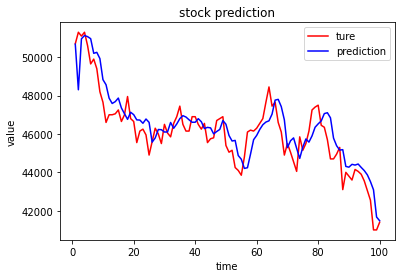

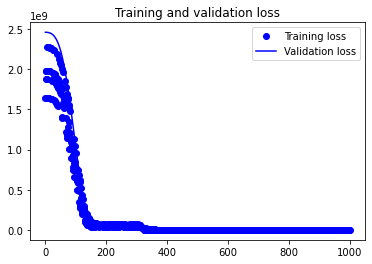

In [13]:

test_data_X, test_data_Y=data_gen_test[0]
prediction_Y=model.predict(test_data_X).flatten()
Y_test=test_data_Y.flatten()

visual_y=[]
visual_pre_y=[]
for i in range(len(prediction_Y)):
    label = Y_test[i]
    prediction = prediction_Y[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))
    visual_y.append(label)
    visual_pre_y.append(prediction)

time = range(1, len(visual_y) + 1)
plt.plot(time, visual_y, 'r', label='ture')
plt.plot(time, visual_pre_y, 'b', label='prediction')
plt.title('stock prediction')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()